In [ ]:
### Import libraries
import math
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [32]:
## Read data and rename columns ###
orig_data = pd.read_excel("OppScrData.xlsx")
for col in orig_data.columns:
    new_col = '_'.join(col.split())
    orig_data.rename(columns={col:new_col}, inplace=True)

# Predicting Death (DEATH_[d_from_CT])

In [33]:
## Data setup for predicting 'DEATH_[d_from_CT]'

data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

## Zero the NULL values
data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)


### Convert percentage values into uniform numeric values
col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)


## clip outliers to 95th percentile
for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

    
data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)


## The main column we are predicting is stored in 'days'
data['days'] = data['DEATH_[d_from_CT]']

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)


data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)

## Created a new column of Fat are/ Total body area
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
#data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())

### Below features filled by iterative imputing

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:, 2]

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


In [34]:
cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()
data['death_binary'] = np.where(data['days'].isna(),0,1)

In [35]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]

In [36]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]

In [37]:
## Create separate sets of train and test based on category of features picked.

all_feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']


ct_feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

feats = all_feats ## To pick all the features
#feats = [x for x in all_feats if x not in ct_feats] ## To pick only clinical features
#feats = ct_feats  ## To pick only CT features

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values
X_test = test[feats].values
Y_test = test[label].values
print(X_test.shape)
print(X_val.shape)
print(Y_val.shape)

(1860, 26)
(130, 26)
(130,)


## Linear Regression

In [38]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

## XGBoost

In [ ]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

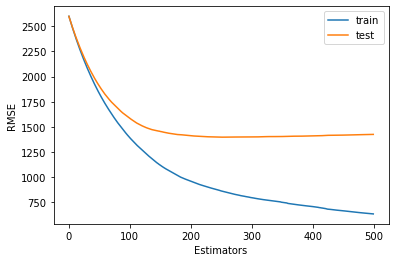

In [12]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('RMSE')
plt.show()

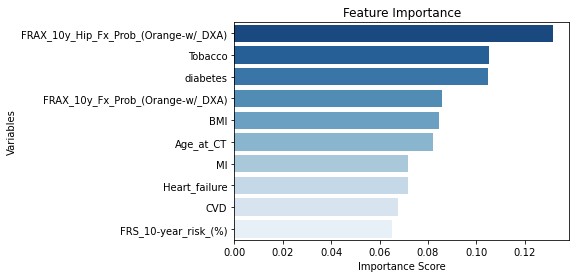

In [13]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])

# print(variables_df)
# print(importance_score_df)

feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:10], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

## Support Vector Regressor

In [ ]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)

RMSE= 1314.3606540232063 Test samples mean= 2251.4153846153845
(130,)


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

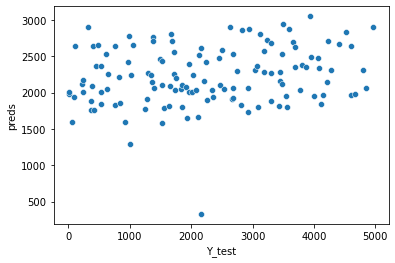

In [40]:
## Predict on Non NULL test samples

preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print("RMSE=",rmse, "Test samples mean=", Y_val.mean())

print(Y_val.shape)
tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [42]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
# print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
# print(tmp_df.describe())

all_preds = model.predict(X_test)
tmp_df = pd.DataFrame(all_preds)
# print(tmp_df.describe())


tmp = {'Y_test':Y_test,'preds':all_preds}
tmp_df = pd.DataFrame(tmp)
y_nz = tmp_df[~tmp_df['Y_test'].isna()]['Y_test']
preds_nz = tmp_df[~tmp_df['Y_test'].isna()]['preds']
rmse = math.sqrt(mean_squared_error(y_nz, preds_nz))
print("Error% for Non-zero values: {:0.4f}".format((rmse/y_nz.mean())))

Error% for Non-zero values: 0.5838


<AxesSubplot:xlabel='Y_test_cat', ylabel='preds'>

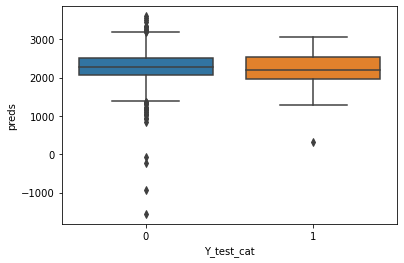

In [43]:
## categorize non null and null labels separately.

tmp = {'Y_test':Y_test,'preds':all_preds}
tmp_df = pd.DataFrame(tmp)
tmp_df['Y_test_cat'] = np.where(tmp_df['Y_test'].isna(), 0, 1)
sns.boxplot(data=tmp_df, x='Y_test_cat', y='preds')

# Predicting Diabetes days from CT

In [45]:
## data setup for predicting diabetes

data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)

data['days'] = data['Type_2_Diabetes_DX_Date_[d_from_CT]']
data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())


### Below features filled by iterative imputing

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
# ind = data.index[data[col].isna()].tolist()
#print(len(data.loc[data[col] < 100, col]))
#print(data.loc[data[col].isna(), 'L1_HU_BMD'])
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)
# print(X[:, 2])
data[col] = X[:, 2]
# print(col, data[col].isna().sum())

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

In [47]:
cols = ['Record_ID', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

data = data[cols].copy()

In [48]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]

In [49]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]

In [50]:
feats = ['BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
        'CVD', 'Heart_failure', 'MI', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
Y_val = val[label].values

## Linear Regression

In [51]:
model = LinearRegression()
model.fit(X_train, Y_train)

LinearRegression()

## XGBoost

In [52]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=250, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

[0]	validation_0-rmse:2191.65063	validation_1-rmse:2186.49463
[1]	validation_0-rmse:2179.72559	validation_1-rmse:2177.61011
[2]	validation_0-rmse:2167.95801	validation_1-rmse:2168.73999
[3]	validation_0-rmse:2156.35425	validation_1-rmse:2160.02344
[4]	validation_0-rmse:2144.81323	validation_1-rmse:2151.52026
[5]	validation_0-rmse:2133.52295	validation_1-rmse:2143.28174
[6]	validation_0-rmse:2122.25439	validation_1-rmse:2134.99585
[7]	validation_0-rmse:2111.19385	validation_1-rmse:2126.86768
[8]	validation_0-rmse:2100.28076	validation_1-rmse:2119.08569
[9]	validation_0-rmse:2089.50342	validation_1-rmse:2111.53467
[10]	validation_0-rmse:2078.95679	validation_1-rmse:2103.74756
[11]	validation_0-rmse:2068.47437	validation_1-rmse:2096.35083
[12]	validation_0-rmse:2058.04761	validation_1-rmse:2088.86035
[13]	validation_0-rmse:2047.90478	validation_1-rmse:2081.68481
[14]	validation_0-rmse:2037.93652	validation_1-rmse:2074.84180
[15]	validation_0-rmse:2027.97705	validation_1-rmse:2067.77124
[1

[130]	validation_0-rmse:1401.65564	validation_1-rmse:1751.10718
[131]	validation_0-rmse:1399.26782	validation_1-rmse:1750.21777
[132]	validation_0-rmse:1395.88623	validation_1-rmse:1749.73987
[133]	validation_0-rmse:1393.43835	validation_1-rmse:1749.16211
[134]	validation_0-rmse:1390.37732	validation_1-rmse:1748.60339
[135]	validation_0-rmse:1388.05872	validation_1-rmse:1747.96619
[136]	validation_0-rmse:1385.26099	validation_1-rmse:1747.35327
[137]	validation_0-rmse:1382.93616	validation_1-rmse:1746.77637
[138]	validation_0-rmse:1379.82507	validation_1-rmse:1746.29907
[139]	validation_0-rmse:1377.37415	validation_1-rmse:1745.65405
[140]	validation_0-rmse:1374.25049	validation_1-rmse:1745.13709
[141]	validation_0-rmse:1372.25281	validation_1-rmse:1744.74646
[142]	validation_0-rmse:1369.25562	validation_1-rmse:1744.25403
[143]	validation_0-rmse:1367.15442	validation_1-rmse:1743.68494
[144]	validation_0-rmse:1364.56531	validation_1-rmse:1743.49194
[145]	validation_0-rmse:1362.49731	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=250, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

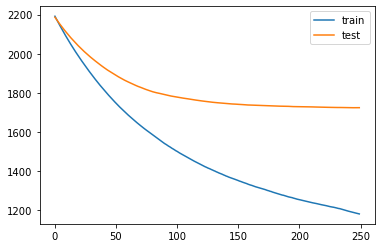

In [53]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.show()

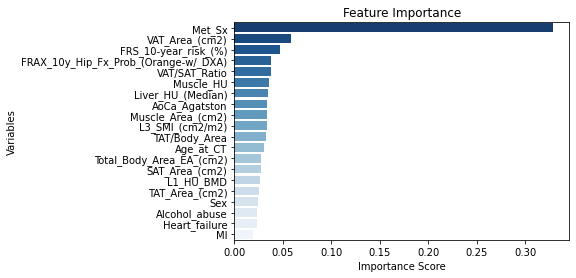

In [130]:
variables_df = pd.DataFrame(feats, columns=['Variables'])
importance_score_df = pd.DataFrame(model.feature_importances_, columns=['Importance Score'])
feature_imp = pd.concat([variables_df, importance_score_df], axis=1)
feature_imp = feature_imp.sort_values(by='Importance Score', ascending=False)
feature_imp = feature_imp.reset_index()
x = 'Importance Score'
y = 'Variables'
sns.barplot(x=x, y=y, data=feature_imp[:20], orient="h", palette="Blues_r")
plt.title('Feature Importance')
plt.show()

## Support Vector Regressor

In [54]:
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

model = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
model.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

rmse= 1885.093399465469 Y_val mean= 1127.566866267465


<AxesSubplot:xlabel='Y_test', ylabel='preds'>

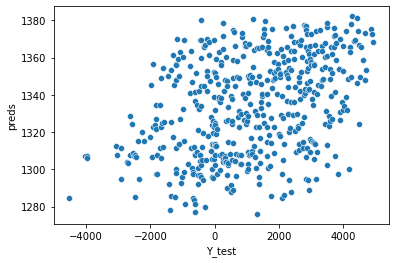

In [55]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print("rmse=", rmse, "Y_val mean=", Y_val.mean())

tmp = {'Y_test':Y_val,'preds':preds} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')

In [56]:
# Prediting on Null values

test_null = test[test['days'].isna()]
X_test_null = test_null[feats].values
preds_test_null = model.predict(X_test_null)

tmp_df = pd.DataFrame(preds)
print(tmp_df.describe())
tmp_df = pd.DataFrame(preds_test_null)
print(tmp_df.describe())

                 0
count   501.000000
mean   1333.780692
std      26.349536
min    1276.019173
25%    1309.881931
50%    1334.710987
75%    1356.219589
max    1382.131492
                 0
count  1359.000000
mean   1352.130514
std      20.713508
min    1282.085836
25%    1339.720823
50%    1358.058078
75%    1368.503917
max    1382.128012


## Predicting Biological Age

In [78]:
## Predicting biological age using decay function

data = orig_data.copy()

data['BMI_>30'] = np.where(data['BMI_>30']=='Y', 1, 0)
data.rename(columns={'BMI_>30':'BMI_more_than_30'}, inplace=True)
data['Sex'] = np.where(data['Sex']=='Male', 1, 0)
data['Tobacco'] = np.where(data['Tobacco']=='Yes', 1, 0)

data['Alcohol_abuse'] = np.where(data['Alcohol_abuse'].isna(),0,1)

col = 'FRS_10-year_risk_(%)'
data[col] = data[col].astype(str)
data[col] = data[col].str.replace('X','')
data[col] = data[col].str.replace('<1%',str(np.random.uniform(0, 0.01)))
data[col] = data[col].str.replace('>30%',str(np.random.uniform(0.3, 0.99)))
data[col] = pd.to_numeric(data[col], errors='coerce')
data[col] = data[col].astype(float)
med = data[col].median()
data[col] = data[col].fillna(med)
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)

for col in ['FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)']:
    data[col] = data[col].astype(str)
    data[col] = data[col].str.replace('_','')
    data[col] = pd.to_numeric(data[col], errors='coerce')
    data[col] = data[col].astype(float)
    med = data[col].median()
    data[col] = data[col].fillna(med)
    upper_limit = data[col].quantile(0.95)
    data[col] = data[col].clip(upper_limit)

data['Met_Sx'] = np.where(data['Met_Sx']=='Y', 1, np.where(data['Met_Sx']=='N', 0, -1))


data['CVD'] = np.where(data['CVD_DX'].isna(),0,1)
data['MI'] = np.where(data['MI_DX'].isna(),0,1)
data['Heart_failure'] = np.where(data['Heart_failure_DX'].isna(),0,1)


max_bio_subtract = 80000
decay_rate = 0.0001
max_bio_age = 100

data['Decay_Days'] = 18 + max_bio_subtract*(1 - np.exp(-decay_rate*data['DEATH_[d_from_CT]']))
data['Bio_Age_AT_CT[DAYS]'] = max_bio_age*365 - data['Decay_Days']


data['days'] = data['Bio_Age_AT_CT[DAYS]']

data['diabetes'] = np.where(data['Type_2_Diabetes_DX'].isna(), 0, 1)

data['L1_HU_BMD'] = data['L1_HU_BMD'].clip(lower=0)
data['TAT/Body_Area'] = data['TAT_Area_(cm2)']/data['Total_Body_Area_EA_(cm2)']
col = 'VAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'SAT_Area_(cm2)'
upper_limit = data[col].quantile(0.99)
data[col] = data[col].clip(upper_limit)
col = 'VAT/SAT_Ratio'
upper_limit = data[col].quantile(0.95)
data[col] = data[col].clip(upper_limit)

data['AoCa_Agatston'] = data['AoCa_Agatston'].clip(upper=data['AoCa_Agatston'].quantile(0.99))
data['AoCa_Agatston'] = data['AoCa_Agatston'].fillna(data['AoCa_Agatston'].median())
data['AoCa_Agatston'] = np.log(data['AoCa_Agatston']+1)

data['Liver_HU_(Median)'] = pd.to_numeric(data['Liver_HU_(Median)'], errors='coerce')
data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].astype(float)
#data['Liver_HU_(Median)'] = data['Liver_HU_(Median)'].fillna(data['Liver_HU_(Median)'].median())
                          
for col in ['BMI','TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'VAT_Area_(cm2)','SAT_Area_(cm2)',
            'Muscle_Area_(cm2)','TAT/Body_Area']:
    data[col] = data[col].fillna(data[col].median())


### Below features filled by iterative imputing

impute_it = IterativeImputer()

col = 'L1_HU_BMD'
rel_cols = ['Age_at_CT', 'Muscle_HU', 'L1_HU_BMD']
X = data[rel_cols]
X = impute_it.fit_transform(X)

data[col] = X[:, 2]

### VAT/SAT ratio -- Muscle area, Sex

col = 'VAT/SAT_Ratio'
rel_cols = ['Muscle_Area_(cm2)', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


col = 'Muscle_HU'
rel_cols = ['Age_at_CT', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]

col = 'L3_SMI_(cm2/m2)'
rel_cols = ['BMI_more_than_30', 'Sex', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]
                       

col = 'Liver_HU_(Median)'                                     
rel_cols = ['BMI_more_than_30', 'TAT/Body_Area', col]
X = data[rel_cols]
X = impute_it.fit_transform(X)
data[col] = X[:,2]


In [79]:
cols = ['Record_ID', 'Clinical_F/U_interval_[d_from_CT]', 'BMI', 'BMI_more_than_30', 'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse',
       'FRS_10-year_risk_(%)', 'FRAX_10y_Fx_Prob_(Orange-w/_DXA)',
       'FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx',
       'days', 'CVD', 'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD',
       'TAT_Area_(cm2)', 'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

#print(data['BMI_>30'])
data = data[cols].copy()
data['death_binary'] = np.where(data['days'].isna(),0,1)

In [80]:
train_idx = pd.read_csv('Patients(RECORD_ID)TrainData.csv')['Record_ID']
test_idx = pd.read_csv('Patients(RECORD_ID)_TestData.csv')['Record_ID']
train = data[data['Record_ID'].isin(train_idx)]
test = data[data['Record_ID'].isin(test_idx)]

In [81]:
# Train on Non-Null values
train = train[~train['days'].isna()]
val = test[~test['days'].isna()]

In [82]:
all_feats = ['BMI', 'BMI_more_than_30',
       'Sex', 'Age_at_CT', 'Tobacco', 'Alcohol_abuse', 'FRS_10-year_risk_(%)',
       'FRAX_10y_Fx_Prob_(Orange-w/_DXA)','FRAX_10y_Hip_Fx_Prob_(Orange-w/_DXA)', 'Met_Sx', 'CVD',
       'Heart_failure', 'MI', 'diabetes', 'L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']


ct_feats = ['L1_HU_BMD', 'TAT_Area_(cm2)',
       'Total_Body_Area_EA_(cm2)', 'TAT/Body_Area', 'VAT_Area_(cm2)',
       'SAT_Area_(cm2)', 'VAT/SAT_Ratio', 'Muscle_HU', 'Muscle_Area_(cm2)',
       'L3_SMI_(cm2/m2)', 'AoCa_Agatston', 'Liver_HU_(Median)']

feats = all_feats
#feats = [x for x in all_feats if x not in ct_feats]
#feats = ct_feats

label = 'days'
X_train = train[feats].values
Y_train = train[label].values
X_val = val[feats].values
chrono_val = val['Age_at_CT'].values
Y_val = val[label].values
X_test = test[feats].values
Y_test = test[label].values
chrono_test = test['Age_at_CT'].values

## XGboost

In [83]:
eval_set = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBRegressor(n_estimators=500, max_depth=7, eta=0.01, subsample=1, colsample_bytree=1)
model.fit(X_train, Y_train, eval_metric='rmse', eval_set=eval_set)

[0]	validation_0-rmse:22175.58594	validation_1-rmse:22417.25781
[1]	validation_0-rmse:21981.87500	validation_1-rmse:22235.08789
[2]	validation_0-rmse:21790.26367	validation_1-rmse:22054.91602
[3]	validation_0-rmse:21600.72852	validation_1-rmse:21877.02930
[4]	validation_0-rmse:21413.25391	validation_1-rmse:21701.10352
[5]	validation_0-rmse:21227.81836	validation_1-rmse:21527.12305
[6]	validation_0-rmse:21043.94336	validation_1-rmse:21359.90820
[7]	validation_0-rmse:20861.99609	validation_1-rmse:21192.78906
[8]	validation_0-rmse:20681.64844	validation_1-rmse:21027.32031
[9]	validation_0-rmse:20504.02734	validation_1-rmse:20865.96680
[10]	validation_0-rmse:20327.53516	validation_1-rmse:20704.65625
[11]	validation_0-rmse:20153.28711	validation_1-rmse:20544.91406
[12]	validation_0-rmse:19980.98828	validation_1-rmse:20389.48438
[13]	validation_0-rmse:19810.41602	validation_1-rmse:20232.50195
[14]	validation_0-rmse:19641.38867	validation_1-rmse:20079.17383
[15]	validation_0-rmse:19474.47656	

[127]	validation_0-rmse:8243.23828	validation_1-rmse:10983.42578
[128]	validation_0-rmse:8192.30273	validation_1-rmse:10954.85254
[129]	validation_0-rmse:8141.78711	validation_1-rmse:10924.98438
[130]	validation_0-rmse:8090.34375	validation_1-rmse:10894.42481
[131]	validation_0-rmse:8040.92969	validation_1-rmse:10867.27539
[132]	validation_0-rmse:7990.55371	validation_1-rmse:10837.81152
[133]	validation_0-rmse:7942.48389	validation_1-rmse:10811.61035
[134]	validation_0-rmse:7892.66113	validation_1-rmse:10783.58203
[135]	validation_0-rmse:7845.33984	validation_1-rmse:10759.20508
[136]	validation_0-rmse:7797.21875	validation_1-rmse:10732.43359
[137]	validation_0-rmse:7750.36035	validation_1-rmse:10705.59863
[138]	validation_0-rmse:7704.38672	validation_1-rmse:10684.11231
[139]	validation_0-rmse:7657.26562	validation_1-rmse:10659.36328
[140]	validation_0-rmse:7611.46387	validation_1-rmse:10633.06543
[141]	validation_0-rmse:7566.29932	validation_1-rmse:10610.42773
[142]	validation_0-rmse:7

[255]	validation_0-rmse:4483.45605	validation_1-rmse:9411.85938
[256]	validation_0-rmse:4469.50781	validation_1-rmse:9407.82519
[257]	validation_0-rmse:4456.09180	validation_1-rmse:9406.44238
[258]	validation_0-rmse:4442.64990	validation_1-rmse:9404.90234
[259]	validation_0-rmse:4424.37207	validation_1-rmse:9402.17773
[260]	validation_0-rmse:4412.17920	validation_1-rmse:9397.99121
[261]	validation_0-rmse:4398.16357	validation_1-rmse:9395.12891
[262]	validation_0-rmse:4384.99316	validation_1-rmse:9394.72363
[263]	validation_0-rmse:4365.92676	validation_1-rmse:9393.00977
[264]	validation_0-rmse:4353.52100	validation_1-rmse:9391.75977
[265]	validation_0-rmse:4341.04785	validation_1-rmse:9389.40918
[266]	validation_0-rmse:4323.46777	validation_1-rmse:9387.81250
[267]	validation_0-rmse:4310.99316	validation_1-rmse:9386.67969
[268]	validation_0-rmse:4298.94580	validation_1-rmse:9384.83496
[269]	validation_0-rmse:4286.32617	validation_1-rmse:9382.39551
[270]	validation_0-rmse:4271.16846	valid

[384]	validation_0-rmse:3083.87329	validation_1-rmse:9370.10547
[385]	validation_0-rmse:3077.06030	validation_1-rmse:9369.26953
[386]	validation_0-rmse:3069.53906	validation_1-rmse:9370.10059
[387]	validation_0-rmse:3063.47949	validation_1-rmse:9370.13965
[388]	validation_0-rmse:3057.86597	validation_1-rmse:9369.32031
[389]	validation_0-rmse:3051.91919	validation_1-rmse:9369.38672
[390]	validation_0-rmse:3046.41968	validation_1-rmse:9368.60254
[391]	validation_0-rmse:3040.05200	validation_1-rmse:9368.92481
[392]	validation_0-rmse:3035.09033	validation_1-rmse:9368.94727
[393]	validation_0-rmse:3028.05444	validation_1-rmse:9369.77051
[394]	validation_0-rmse:3021.45361	validation_1-rmse:9370.95801
[395]	validation_0-rmse:3013.97607	validation_1-rmse:9371.21289
[396]	validation_0-rmse:3007.15503	validation_1-rmse:9372.07422
[397]	validation_0-rmse:3001.16919	validation_1-rmse:9370.33887
[398]	validation_0-rmse:2995.71045	validation_1-rmse:9371.00195
[399]	validation_0-rmse:2990.34790	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             eta=0.01, gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_delta_step=0, max_depth=7, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

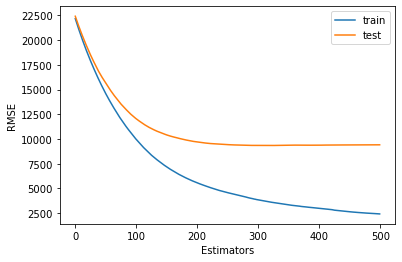

In [84]:
results = model.evals_result()
plt.plot(results['validation_0']['rmse'], label='train')
plt.plot(results['validation_1']['rmse'], label='test')
plt.legend()
plt.xlabel('Estimators')
plt.ylabel('RMSE')
plt.show()

9408.819972918758 20924.475699779592
(130,)


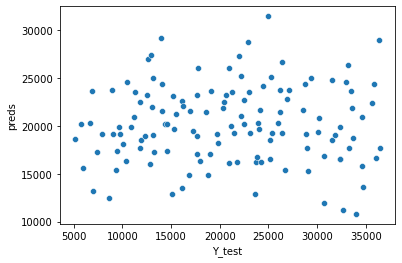

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_env/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


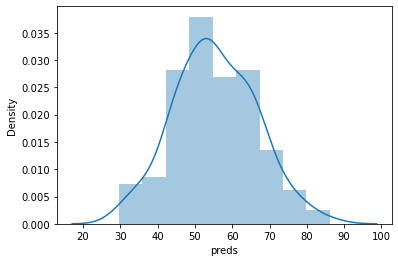

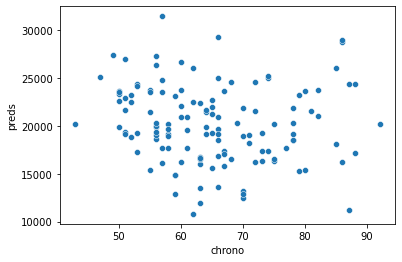

In [85]:
preds = model.predict(X_val)
rmse = math.sqrt(mean_squared_error(Y_val, preds))
print(rmse, Y_val.mean())

print(Y_val.shape)

tmp = {'Y_test':Y_val,'preds':preds, 'chrono': chrono_val} 
tmp_df = pd.DataFrame(tmp)
tmp_df.sort_values(by='Y_test', inplace=True)
sns.scatterplot(data=tmp_df, x='Y_test', y='preds')
plt.show()
sns.distplot(tmp_df['preds']/365)
plt.show()
sns.scatterplot(data=tmp_df, x='chrono', y='preds')
plt.show()